# EpiFRIenDs on different distributions 

In this notebook we show some examples of how to apply EpiFRIenDs using mock data with different spatial distributions.

## Importing modules

We first import the modules required from this notebook. Notice that, apart from the packages already required by EpiFRIenDs, matplotlib is also necessary here.

In [11]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from epifriends import epifriends
import os

## Defining functions 

These functions are used for this notebook to generate mock random data:

In [12]:
def generate_mock_data(population_size, positivity_rate, positive_distribution, \
                       seed = None, save = True, output_file = 'mock_dataframe.csv'):
    """
    This method generates mock data of a spatial distribution
    of negative and positive cases.

    Parameters:
    -----------
    population_size: int
        Sample size
    positivity_rate: float
        Fraction of positive cases
    positive_distribution: str {'rand', 'clustered', 'sinusoidal'}
        Option for the distribution of positive cases
    seed: int
        Random seed for the random number generation
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file

    Returns:
    --------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    position_rand: np.ndarray
        2D-vector with x and y positions
    positive: np.array
        Boolean mask for positive cases
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    if seed is not None:
        np.random.seed(seed)
    #Negative cases
    x_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    y_rand = np.random.rand(int(population_size*(1 - positivity_rate)))
    #Positive cases
    if positive_distribution == 'rand':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = np.random.rand(int(population_size*positivity_rate))
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
    elif positive_distribution == 'sinusoidal':
        x_rand_p = np.random.rand(int(population_size*positivity_rate))
        y_rand_p = .5 + .5*np.sin(10*x_rand_p)
        #Concatenating all cases
        x_rand = np.concatenate((x_rand, x_rand_p))
        y_rand = np.concatenate((y_rand, y_rand_p))
    elif positive_distribution == 'clustered':
        for i in range(4):
            x_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/4))
            y_rand_p = np.random.normal(.1 + .8*np.random.rand(), .05, int(population_size*positivity_rate/4))
            #Concatenating all cases
            x_rand = np.concatenate((x_rand, x_rand_p))
            y_rand = np.concatenate((y_rand, y_rand_p))
    #2D vector for positions
    position_rand = np.array([x_rand,y_rand]).T
    #Defining positivity and test result
    positive = np.arange(population_size) > population_size*(1 - positivity_rate)
    test_rand = np.array(positive, dtype = float)
    mock_df = get_mock_dataframe(x_rand, y_rand, test_rand, save, output_file)
    return x_rand, y_rand, position_rand, positive, test_rand, mock_df

def get_mock_dataframe(x_rand, y_rand, test_rand, save = True, output_file = 'mock_dataframe.csv'):
    """
    This method creates a dataframe of the mock data.

    Parameters:
    -----------
    x_rand: np.array
        Positions in x-axis
    y_rand: np.array
        Positions in y-axis
    test_rand: np.array
        Test results, 1 for positive, 0 for negative
    save: bool
        If true, the dataframe is saved as a csv
    output_file: str
        Name of output file

    Returns:
    --------
    mock_df: pd.DataFrame
        Dataframe of the mock data
    """
    mock_df = pd.DataFrame(
    {
        'id' : np.arange(len(x_rand), dtype = int),
        'x' : x_rand,
        'y' : y_rand,
        'test' : test_rand,
        'case_count' : np.ones_like(x_rand),
        'dates' : pd.to_datetime(['2017-02-02' for i in range(len(x_rand))])
    })
    mock_df = geopandas.GeoDataFrame(mock_df, geometry = geopandas.points_from_xy(mock_df['x'], mock_df['y']))
    if save:
        mock_df.to_csv(output_file)
    return mock_df

def size_histogram(catalogue):
    """
    This method shows a histogram of the size (total number of cases) in foci 
    for foci with p>0.05 and with p<0.05. 
    
    Parameters:
    -----------
    catalogue: geopandas.DataFrame
        Dataframe of the EpiFRIenDs catalogue
    
    Returns:
    --------
    Histogram of number of foci per total number of cases with p<0.05 in red 
    and p>0.05 in blue.
    """
    hist_all, edges, patches = plt.hist(catalogue['total'], 20, \
                                        range = [np.min(catalogue['total']), \
                                                np.max(catalogue['total'])], \
                                        color = 'tab:red', label = 'p < 0.05')
    hist_highp, edges, patches = plt.hist(catalogue['total'][catalogue['p']>.05], 20, \
                                          range = [np.min(catalogue['total']), \
                                          np.max(catalogue['total'])], \
                                          color = 'tab:blue', label = 'p > 0.05')
    plt.ylabel("Number of foci")
    plt.xlabel("Number of cases in foci")
    plt.legend()
    plt.show()
    
def scatter_pval(x_data, y_data, id_data, positive, epi_catalogue):
    """
    This method shows a scatter plot of the data distribution, showing in 
    colour the positive cases that belong to foci (with the colour 
    representing their p-value) and in grey the rest of the data. 
    
    Parameters:
    -----------
    x_data: np.array
        Array with the values of the x-coordinate
    y_data: np.array
        Array with the values of the y-coordinate
    id_data: np.array
        Array with the cluster ID associated to each positive case, o for 
        no associated cluster
    positive: np.array
        Boolean array indicated if the case is infected. 
    epi_catalogue: geopandas.DataFrame
        Dataframe of the EpiFRIenDs catalogue
    
    Returns:
    --------
    Scatter plot of the data distribution, showing in 
    colour the positive cases that belong to foci (with the colour 
    representing their p-value) and in grey the rest of the data. 
    """
    plt.scatter(x_data, y_data, c = 'tab:grey')
    p_vals = np.array([epi_catalogue[epi_catalogue['id'] == i]['p'] for i in id_data[id_data > 0]], \
                        dtype = float)
    plt.scatter(x_data[positive][id_data > 0], y_data[positive][id_data > 0], \
                c = p_vals, cmap = 'turbo')
    plt.colorbar()
    plt.title("P-value of hotspots")
    plt.show()

## Create mock data 

Here we define and create the mock data for the examples shown in this notebook. 

In [15]:
#This defines the path to store the data generated if desired
mock_data_path = "~/Desktop/"

In [17]:
#Fixing a random seed to reproduce the results (to be) published
seed = 56826294
#Defining the population size and positivity rate of the mock data
population_size = 1000
positivity_rate = .2

#Generating random distribution of positives
file_name = 'mock_data_rand.csv'
x_rand, y_rand, position_rand, positive_rand, test_rand, \
mock_rand = generate_mock_data(population_size, positivity_rate, 'rand', seed = seed, \
                               output_file = os.path.join(mock_data_path, file_name), \
                               save = False)

#Generating 4 random clusters of positives
file_name = 'mock_data_clustered.csv'
x_clust, y_clust, position_clust, positive_clust, test_clust, \
mock_clust = generate_mock_data(population_size, positivity_rate, 'clustered', seed = seed, \
                                output_file = os.path.join(mock_data_path, file_name), \
                                save = False)

#Generating sinusoidal distribution of positives
file_name = 'mock_data_sin.csv'
x_sin, y_sin, position_sin, positive_sin, test_sin, \
mock_sin = generate_mock_data(population_size, positivity_rate, 'sinusoidal', seed = seed, \
                              output_file = os.path.join(mock_data_path, file_name), \
                              save = False)

This is the spatial distribution of negative (in blue) and positive (in red) cases of the three mock data catalogues created: 

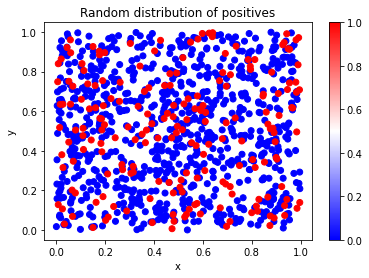

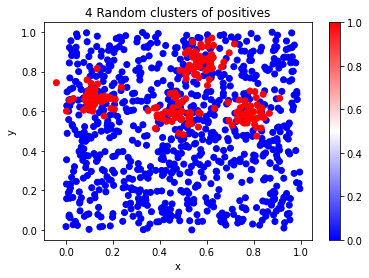

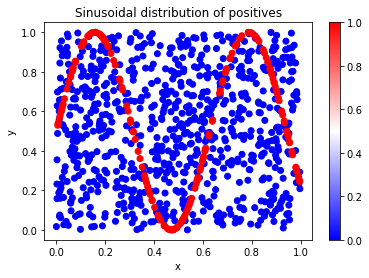

In [20]:
#Plots
plt.scatter(x_rand, y_rand, c = test_rand, cmap = 'bwr')
plt.colorbar()
plt.title("Random distribution of positives")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.scatter(x_clust, y_clust, c = test_clust, cmap = 'bwr')
plt.colorbar()
plt.title("4 Random clusters of positives")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.scatter(x_sin, y_sin, c = test_sin, cmap = 'bwr')
plt.colorbar()
plt.title("Sinusoidal distribution of positives")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Running EpiFRIenDs 

We first define the two main parameters of the method: 

- `link_d`, the linking distance: this distance is used to link the data points so that points that are closer than this distance are candidates to join and form part of the same cluster. The other parameter, `min_neighbours`, defines if they are actually linked. 

- `min_neighbours`, the minimum number of neighbours: one data point is linked to its neighbours (or friends, defined as the data points closer than `link_d` to it) only if there are at least `min_neighbours` (including itself) to link. This parameter ensures that for each cluster we have at least `min_neighbours` within a radius of `link_d`, plus other data points indirectly linked to them. 


In [48]:
#EpiFRIenDs parameters
link_d = .01
min_neighbours = 2

The function `dbscan` uses these two parameters to identify clusters using the Density-based spatial clustering of applications with noise (DBSCAN) algorithm and returns the cluster ID of each data point, with 0 meaning that the data point does not belong to any cluster. In the EpiFRIenDs algorithm, DBSCAN is applied using only the positive cases in order to detect clusters of infections. In the following example, we select the positions of th first mock dataset of the positive cases only using the mask `positive_rand`, a boolean array indicating if the case is positive. We visualise the result showing the scatter distribution of negative cases in grey and the distribution of positive cases colour coded by the cluster ID (0 meaning that they are not assigned to any cluster).

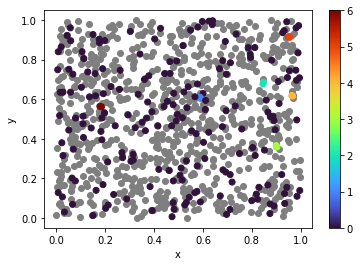

In [54]:
#Running DBSCAN for the mock data with random distributions
cluster_id = epifriends.dbscan(position_rand[positive_rand], link_d, min_neighbours)

#Visualising result
plt.scatter(position_rand[:,0][np.invert(positive_rand)], position_rand[:,1][np.invert(positive_rand)], c = 'tab:grey')
plt.scatter(position_rand[:,0][positive_rand], position_rand[:,1][positive_rand], c = cluster_id, cmap = 'turbo')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

Here we show the same for the second mock dataset:

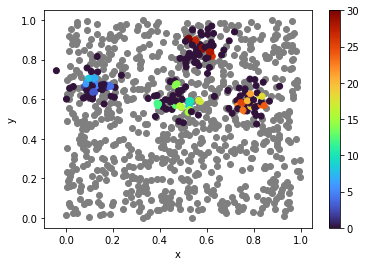

In [55]:
#Running DBSCAN for the mock data with random distributions
cluster_id = epifriends.dbscan(position_clust[positive_clust], link_d, min_neighbours)

#Visualising result
plt.scatter(position_clust[:,0][np.invert(positive_clust)], position_clust[:,1][np.invert(positive_clust)], c = 'tab:grey')
plt.scatter(position_clust[:,0][positive_clust], position_clust[:,1][positive_clust], c = cluster_id, cmap = 'turbo')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

The main method from EpiFRIenDs is the function `catalogue`, that adds the neighbouring negative cases into the clusters by connecting the negative cases into the clusters when they are closer than `link_d` to at least one of the positive cases of each cluster. Notice that, with this approach, one negative case can contribute to two different clusters, since it can be closer than `link_d` to two positive cases from two different clusters that are furthen than `link_d` between them. 

`catalogue` requires as input the positions and test results of the whole data set and the linking distance `link_d`. Optionally, the cluster IDs of the positive cases obtained from the method `dbscan` can be passed as input, otherwise `dbscan` is run on the positive cases as the first step of the function `catalogue`. Finally, `min_neighbours` can also be specified. The default value is 2, corresponding to the case of running the Friends-of-Friends algorithm on the positive cases in the `dbscan` step. 

The method outputs the cluster ID, positivity rate and p-value assigned to each positive case, as well as a geopandas dataframe with the EpiFRIenDs output catalogue, with the following information: 
- 'id': EpiFRIenDs id of the foci
- 'mean_position_pos': Mean position of positive cases
- 'mean_position_all': Mean position of all cases
- 'mean_pr': Positivity rate of the foci
- 'positives': Number of positive cases
- 'negatives': Number of negative cases
- 'total': Total number of positions
- 'indeces': Indeces of all positions
- 'p': p-value of the detection

In the following example we run the method `catalogue` for different values of `link_d` in order to see the impact of this parameter on the detected foci (or clusters).

In [57]:
#EpiFRIenDs parameters
link_d_to_analyse = [.01, .02, .05, .1]
min_neighbours = 2

We run EpiFRIenDs for all values or `link_d` and for the three mock data catalogues. 

Here we show the results of applying different `link_d` to the first mock catalogue with random distributions:

---- Using link_d = 0.01 ----
Number of EpiFRIenDs groups in random data with scale = 0.01: 6 , 3  of which with p<0.05


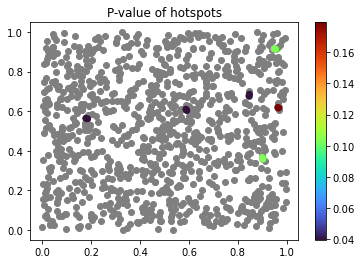

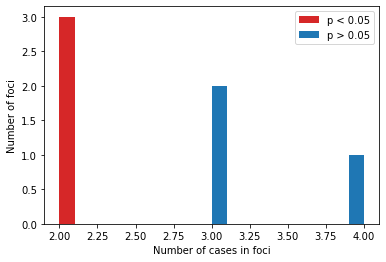

---- Using link_d = 0.02 ----
Number of EpiFRIenDs groups in random data with scale = 0.02: 21 , 5  of which with p<0.05


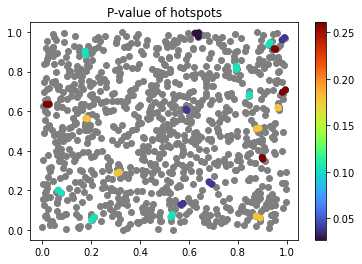

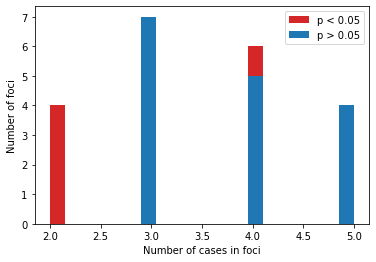

---- Using link_d = 0.05 ----
Number of EpiFRIenDs groups in random data with scale = 0.05: 42 , 0  of which with p<0.05


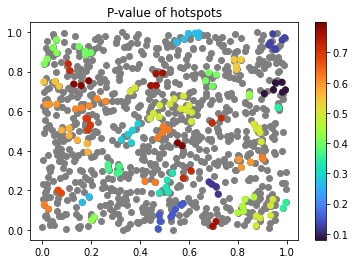

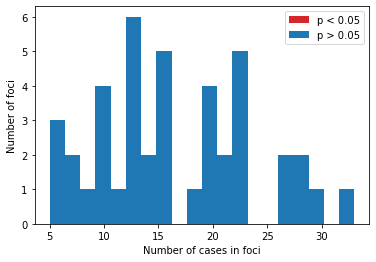

---- Using link_d = 0.1 ----
Number of EpiFRIenDs groups in random data with scale = 0.1: 5 , 0  of which with p<0.05


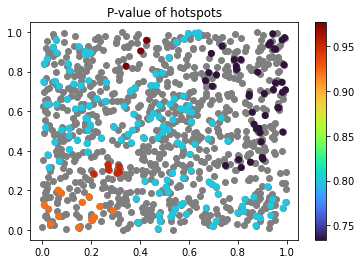

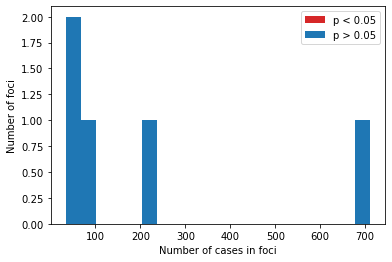

In [67]:
for link_d in link_d_to_analyse:
    print("---- Using link_d = " + str(link_d) + " ----")
    
    #Random distribution
    id_rand, mean_pr_rand, pval_rand, epifriends_catalogue_rand = epifriends.catalogue(position_rand, test_rand, link_d, \
                                                                      cluster_id = None, min_neighbours = min_neighbours)
    print("Number of EpiFRIenDs groups in random data with scale = " + str(link_d) + ":", \
          len(epifriends_catalogue_rand), ",", np.sum(epifriends_catalogue_rand['p'] < 0.05), " of which with p<0.05")
    
    #Scatter distribution of positive cases in foci (colours) and the rest (grey)
    scatter_pval(position_rand[:,0], position_rand[:,1], id_rand, positive_rand, epifriends_catalogue_rand)
    #Histogram of sizes of foci
    size_histogram(epifriends_catalogue_rand)


Here we show the results using the different values of `link_d` in the data with four random clusters of positive cases:

---- Using link_d = 0.01 ----
Number of EpiFRIenDs groups in clustered data with scale = 0.01: 30 , 23  of which with p<0.05


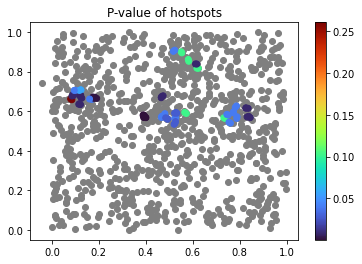

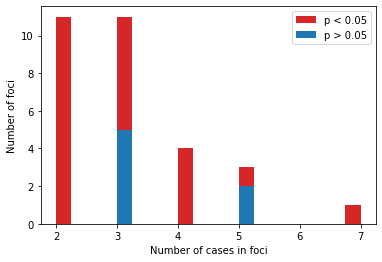

---- Using link_d = 0.02 ----
Number of EpiFRIenDs groups in clustered data with scale = 0.02: 24 , 16  of which with p<0.05


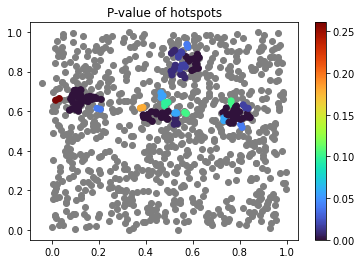

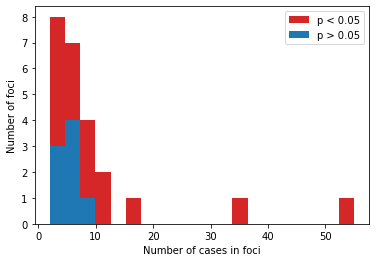

---- Using link_d = 0.05 ----
Number of EpiFRIenDs groups in clustered data with scale = 0.05: 5 , 4  of which with p<0.05


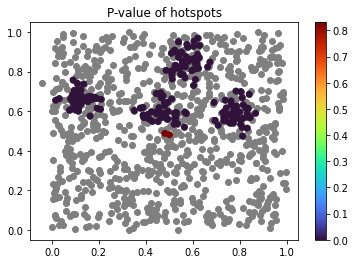

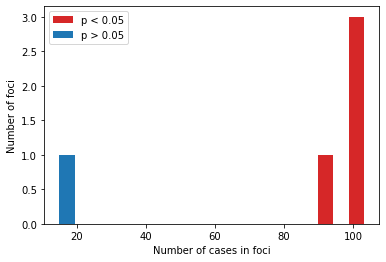

---- Using link_d = 0.1 ----
Number of EpiFRIenDs groups in clustered data with scale = 0.1: 2 , 2  of which with p<0.05


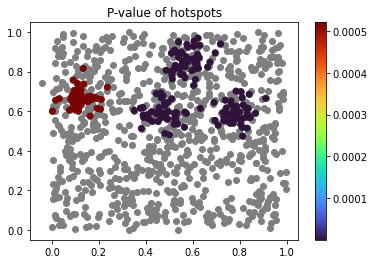

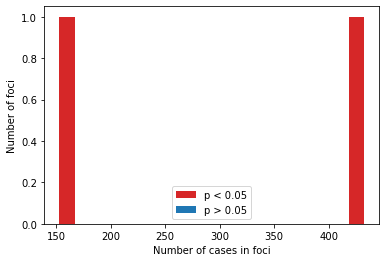

In [68]:
for link_d in link_d_to_analyse:
    print("---- Using link_d = " + str(link_d) + " ----")
    
    #4 clusters
    id_clust, mean_pr_clust, pval_clust, epifriends_catalogue_clust = epifriends.catalogue(position_clust, test_clust, link_d, \
                                                                      cluster_id = None, min_neighbours = min_neighbours)
    print("Number of EpiFRIenDs groups in clustered data with scale = " + str(link_d) + ":", \
          len(epifriends_catalogue_clust), ",", np.sum(epifriends_catalogue_clust['p'] < 0.05), " of which with p<0.05")
    #Scatter distribution of positive cases in foci (colours) and the rest (grey)
    scatter_pval(position_clust[:,0], position_clust[:,1], id_clust, positive_clust, epifriends_catalogue_clust)
    #Histogram of sizes of foci
    size_histogram(epifriends_catalogue_clust)
    

Finally, this shows the results applied to the data set with a sinusoidal distribution of positive cases: 

---- Using link_d = 0.01 ----
Number of EpiFRIenDs groups in sinusoidal data with scale = 0.01: 42 , 37  of which with p<0.05


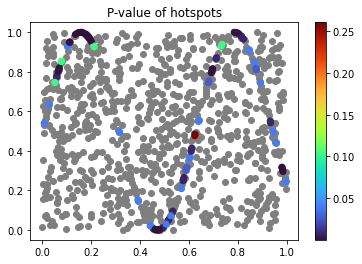

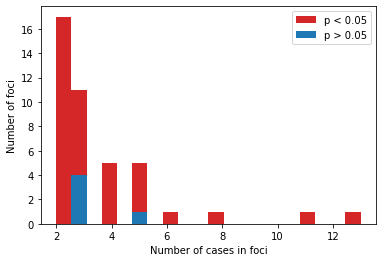

---- Using link_d = 0.02 ----
Number of EpiFRIenDs groups in sinusoidal data with scale = 0.02: 43 , 17  of which with p<0.05


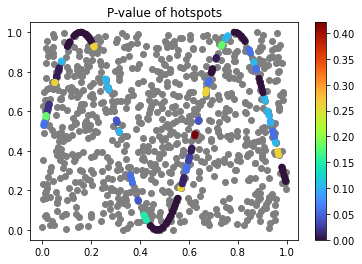

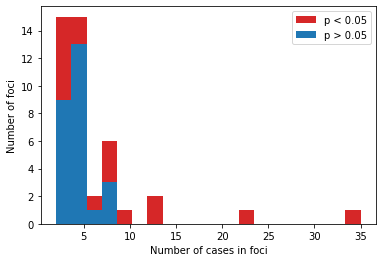

---- Using link_d = 0.05 ----
Number of EpiFRIenDs groups in sinusoidal data with scale = 0.05: 13 , 9  of which with p<0.05


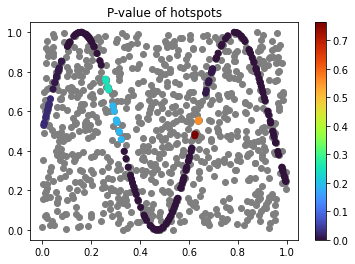

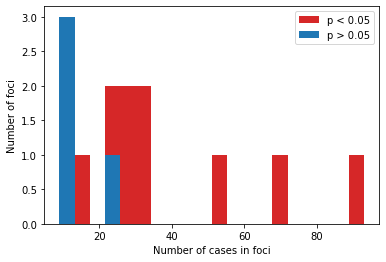

---- Using link_d = 0.1 ----
Number of EpiFRIenDs groups in sinusoidal data with scale = 0.1: 2 , 2  of which with p<0.05


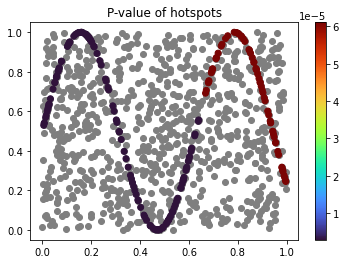

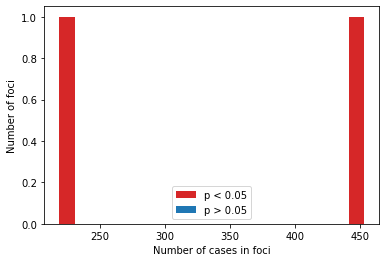

In [69]:
for link_d in link_d_to_analyse:
    print("---- Using link_d = " + str(link_d) + " ----")
    
    #Sinusoidal distribution
    id_sin, mean_pr_sin, pval_sin, epifriends_catalogue_sin = epifriends.catalogue(position_sin, test_sin, link_d, \
                                                                      cluster_id = None, min_neighbours = min_neighbours)
    print("Number of EpiFRIenDs groups in sinusoidal data with scale = " + str(link_d) + ":", \
          len(epifriends_catalogue_sin), ",", np.sum(epifriends_catalogue_sin['p'] < 0.05), " of which with p<0.05")
    #Scatter distribution of positive cases in foci (colours) and the rest (grey)
    scatter_pval(position_sin[:,0], position_sin[:,1], id_sin, positive_sin, epifriends_catalogue_sin)
    #Histogram of sizes of foci
    size_histogram(epifriends_catalogue_sin)

These data sets and results correspond to those from the reference publication of the method (to be published).